In [1]:
from dataclasses import dataclass
from datetime import datetime, timezone
from scipy.stats import norm
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D 
from zoneinfo import ZoneInfo
from IPython.display import clear_output, display

import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import time
import math

In [2]:
def _norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

In [3]:
def bs_price(S, K, T, r, q, sigma, option_type="call"):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    disc_r = math.exp(-r * T)
    disc_q = math.exp(-q * T)
    if option_type == "call":
        return disc_q * S * _norm_cdf(d1) - disc_r * K * _norm_cdf(d2)
    else:
        return disc_r * K * _norm_cdf(-d2) - disc_q * S * _norm_cdf(-d1)

In [4]:
def implied_vol_bisect(price, S, K, T, r, q, option_type="call",
                       lo=1e-6, hi=5.0, tol=1e-6, max_iter=120):
    if not (np.isfinite(price) and price > 0):
        return np.nan
    if T <= 0 or S <= 0 or K <= 0:
        return np.nan

    disc_r = math.exp(-r * T)
    disc_q = math.exp(-q * T)

    # Rough no-arbitrage bounds
    if option_type == "call":
        lower = max(0.0, disc_q * S - disc_r * K)
        upper = disc_q * S
    else:
        lower = max(0.0, disc_r * K - disc_q * S)
        upper = disc_r * K

    if price < lower - 1e-10 or price > upper + 1e-10:
        return np.nan

    f_lo = bs_price(S, K, T, r, q, lo, option_type) - price
    f_hi = bs_price(S, K, T, r, q, hi, option_type) - price
    if not np.isfinite(f_lo) or not np.isfinite(f_hi):
        return np.nan
    if f_lo * f_hi > 0:
        return np.nan

    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        f_mid = bs_price(S, K, T, r, q, mid, option_type) - price
        if not np.isfinite(f_mid):
            return np.nan
        if abs(f_mid) < tol:
            return mid
        if f_lo * f_mid <= 0:
            hi = mid
            f_hi = f_mid
        else:
            lo = mid
            f_lo = f_mid
    return 0.5 * (lo + hi)

In [5]:
def get_spot(tk: yf.Ticker) -> float:
    try:
        s = float(tk.fast_info["last_price"])
        if np.isfinite(s) and s > 0:
            return s
    except Exception:
        pass
    h = tk.history(period="5d", interval="1d")
    if h.empty:
        return np.nan
    return float(h["Close"].dropna().iloc[-1])

In [6]:
def _pick_atm_row_and_price(df: pd.DataFrame, S: float):
    df = df.copy()
    df["strike"] = pd.to_numeric(df["strike"], errors="coerce")
    df = df.dropna(subset=["strike"])
    df["dist"] = (df["strike"] - S).abs()

    bid = pd.to_numeric(df.get("bid"), errors="coerce") if "bid" in df.columns else pd.Series(np.nan, index=df.index)
    ask = pd.to_numeric(df.get("ask"), errors="coerce") if "ask" in df.columns else pd.Series(np.nan, index=df.index)
    last = pd.to_numeric(df.get("lastPrice"), errors="coerce") if "lastPrice" in df.columns else pd.Series(np.nan, index=df.index)

    mid = pd.Series(np.nan, index=df.index)
    good = (bid > 0) & (ask > 0)
    mid.loc[good] = (bid[good] + ask[good]) / 2.0

    price = mid.where(mid > 0, last)
    df["price"] = price

    dfp = df.dropna(subset=["price"])
    dfp = dfp[dfp["price"] > 0]

    if not dfp.empty:
        row = dfp.sort_values("dist").iloc[0]
        return row, float(row["price"])

    row = df.sort_values("dist").iloc[0]
    return row, np.nan

In [7]:
def get_option_iv_dataset(
    ticker: str,
    r: float = 0.04,
    q: float = 0.035,
    use_mid: bool = True,
    option_type: str = "call",
    min_days: int = 15,
    tz_name: str = "America/New_York",
    expiry_hour: int = 16,
    mny_low: float = 0.8,
    mny_high: float = 1.2,
    max_expiries: int = 20,
    max_retries: int = 3,
    sleep_between: float = 0.5
):
    SECONDS_IN_YEAR = 365.25 * 24 * 3600
    tk = yf.Ticker(ticker)

    S = get_spot(tk)
    if not np.isfinite(S) or S <= 0:
        return pd.DataFrame()

    expiries = tk.options
    if not expiries:
        return pd.DataFrame()

    tz = ZoneInfo(tz_name)
    now = datetime.now(tz)
    min_T = min_days / 365.25

    exp_T = []
    for exp in expiries:
        exp_dt = datetime.strptime(exp, "%Y-%m-%d").replace(
            tzinfo=tz, hour=expiry_hour, minute=0, second=0, microsecond=0)
        T = (exp_dt - now).total_seconds() / SECONDS_IN_YEAR
        if T >= min_T:
            exp_T.append((exp, T))
    exp_T.sort(key=lambda x: x[1])
    exp_T = [x for x in exp_T if x[1] <= 3.0]

    if len(exp_T) > 12:
       exp_T = exp_T[:12] + exp_T[-12:]


    rows = []

    for exp, T in exp_T:
        chain = None
        last_err = None
        for k in range(max_retries):
            try:
                chain = tk.option_chain(exp)
                break
            except Exception as e:
                last_err = e
                time.sleep(1.5 * (2 ** k))
        if chain is None:
            continue

        df = chain.calls if option_type == "call" else chain.puts
        if df is None or df.empty:
            continue
        df = df.copy()

        strikes = pd.to_numeric(df.get("strike"), errors="coerce")
        last = pd.to_numeric(df.get("lastPrice"), errors="coerce")

        if use_mid and ("bid" in df.columns) and ("ask" in df.columns):
            bid = pd.to_numeric(df["bid"], errors="coerce")
            ask = pd.to_numeric(df["ask"], errors="coerce")
            mid = (bid + ask) / 2.0
            good_mid = (bid > 0) & (ask > 0) & (mid > 0)
            px = mid.where(good_mid, last)
        else:
            px = last

        ivy_col = df.get("impliedVolatility", None)

        for i in range(len(df)):
            K = strikes.iloc[i]
            opt_px = px.iloc[i]
            ivy = ivy_col.iloc[i] if ivy_col is not None else np.nan

            if not (np.isfinite(K) and K > 0):
                continue

            iv = np.nan
            price_used = np.nan

            if np.isfinite(opt_px) and opt_px > 0:
                iv = implied_vol_bisect(float(opt_px), float(S), float(K), float(T), float(r), float(q), option_type=option_type)
                price_used = float(opt_px)

            # fallback to Yahoo's impliedVolatility
            if (not np.isfinite(iv)) and ivy_col is not None:
                try:
                    ivy = float(ivy)
                except Exception:
                    ivy = np.nan
                if np.isfinite(ivy) and ivy > 0:
                    iv = ivy
                    price_used = np.nan

            if not (np.isfinite(iv) and iv > 0):
                continue

            rows.append({
                "ticker": ticker,
                "S": float(S),
                "expiry": exp,
                "T": float(T),
                "K": float(K),
                "moneyness": float(K) / float(S),
                "option_type": option_type,
                "price_used": price_used,
                "iv": float(iv),
            })

        time.sleep(sleep_between)

    data = pd.DataFrame(rows)
    if data.empty:
        return data

    data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=["iv", "T", "K"])
    data = data[(data["iv"] > 1e-4) & (data["iv"] < 2.0)]
    data = data[(data["moneyness"] >= mny_low) & (data["moneyness"] <= mny_high)]
    return data

In [8]:
def plot_iv_surface_continuous(data, title="IV Surface", x_axis="K", round_T=3, round_x=1):
    df = data.dropna(subset=["iv", "T", x_axis]).copy()

    df["Tg"] = df["T"].round(round_T)
    df["Xg"] = df[x_axis].round(round_x)

    grid = (
        df.pivot_table(index="Tg", columns="Xg", values="iv", aggfunc="median")
          .sort_index()
          .sort_index(axis=1))

    # 3) Interpolation 2D pour remplir les trous (surface continue)
    grid = grid.interpolate(axis=1, limit_direction="both")   # interp sur X (strikes)
    grid = grid.interpolate(axis=0, limit_direction="both")   # interp sur T (maturités)

    # 4) Backup si bords encore NaN
    grid = grid.ffill().bfill().ffill(axis=1).bfill(axis=1)

    X = grid.columns.values.astype(float)
    T = grid.index.values.astype(float)
    Xm, Tm = np.meshgrid(X, T)
    Z = grid.values.astype(float)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(Xm, Tm, Z)  # surface maintenant continue

    ax.set_title(title)
    ax.set_xlabel("Strike (K)" if x_axis=="K" else "Moneyness (K/S)")
    ax.set_ylabel("Maturity T (years)")
    ax.set_zlabel("Implied Vol")
    plt.show() 

In [9]:
def find_working_chain(tk, target_days=30, candidates=8, max_retries=3):
    expiries = tk.options
    if not expiries:
        return None, None

    now = datetime.now(timezone.utc)
    scored = []
    for exp in expiries:
        exp_dt = datetime.strptime(exp, "%Y-%m-%d").replace(tzinfo=timezone.utc)
        days = (exp_dt - now).total_seconds() / 86400
        if days <= 1:
            continue
        scored.append((abs(days - target_days), exp))

    scored.sort(key=lambda x: x[0])
    scored = scored[:candidates]

    for _, exp in scored:
        chain = None
        for k in range(max_retries):
            try:
                chain = tk.option_chain(exp)
                break
            except Exception:
                time.sleep(1.5 * (2 ** k))
        if chain is None:
            continue

        if (chain.calls is not None and not chain.calls.empty) and (chain.puts is not None and not chain.puts.empty):
            return exp, chain

    return None, None

In [10]:
def snapshot_atm_prices(ticker="XOM", target_days=30, max_retries=3):
    tk = yf.Ticker(ticker)

    S = get_spot(tk)
    if not np.isfinite(S) or S <= 0:
        return None, f"Bad spot: {S}"

    exp, chain = find_working_chain(tk, target_days=target_days, candidates=10, max_retries=max_retries)
    if chain is None:
        return None, "No working expiry found (all chains empty/failed)."

    calls = chain.calls
    puts  = chain.puts

    call_row, call_px = _pick_atm_row_and_price(calls, S)
    put_row,  put_px  = _pick_atm_row_and_price(puts,  S)

    snap = {
        "time": datetime.now(timezone.utc),
        "ticker": ticker,
        "spot": float(S),
        "expiry": exp,
        "K_call": float(call_row["strike"]),
        "K_put": float(put_row["strike"]),
        "call_price": float(call_px) if np.isfinite(call_px) else np.nan,
        "put_price": float(put_px) if np.isfinite(put_px) else np.nan,
    }
    return snap, None

Rows: 326 | expiries: 16


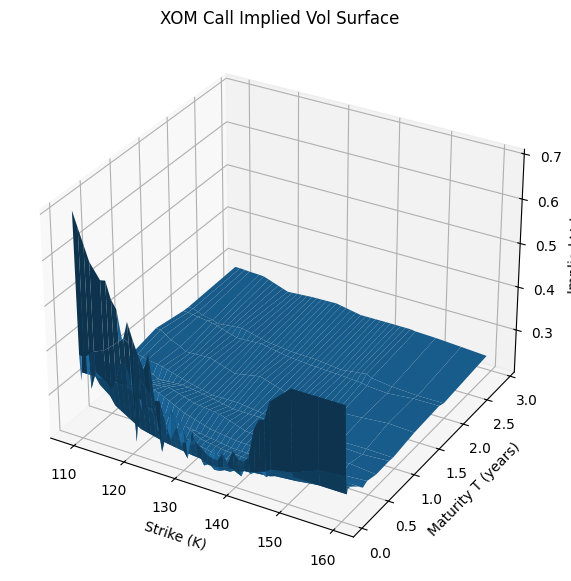

Rows: 286 | expiries: 16


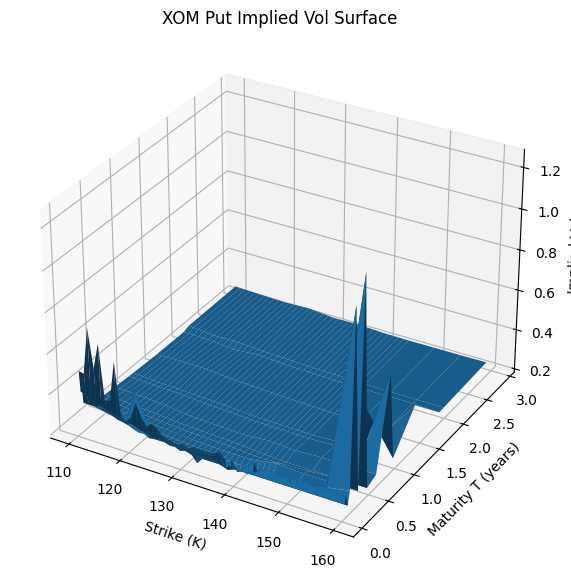

In [16]:
ticker = "XOM"
r = 0.04
q = 0.035

data_call = get_option_iv_dataset(
    ticker=ticker,
    r=r,
    q=q,
    option_type="call",
    min_days=15,
    mny_low=0.8,
    mny_high=1.2,
    max_expiries=12,
    max_retries=3,
    sleep_between=0.4
)

print("Rows:", len(data_call), "| expiries:", data_call["expiry"].nunique() if not data_call.empty else 0)
plot_iv_surface_continuous(data_call, title=f"{ticker} Call Implied Vol Surface", x_axis="K")

data_put = get_option_iv_dataset(ticker=ticker, r=r, q=q, option_type="put", min_days=15,
                                 mny_low=0.8, mny_high=1.2, max_expiries=12)
print("Rows:", len(data_put), "| expiries:", data_put["expiry"].nunique() if not data_put.empty else 0)
plot_iv_surface_continuous(data_put, title=f"{ticker} Put Implied Vol Surface", x_axis="K")

Last update: 18:26:43 UTC | XOM spot=134.76 | exp=2026-02-27 | K_call=135.00 | K_put=135.00 | Call=3.3250 | Put=4.2500


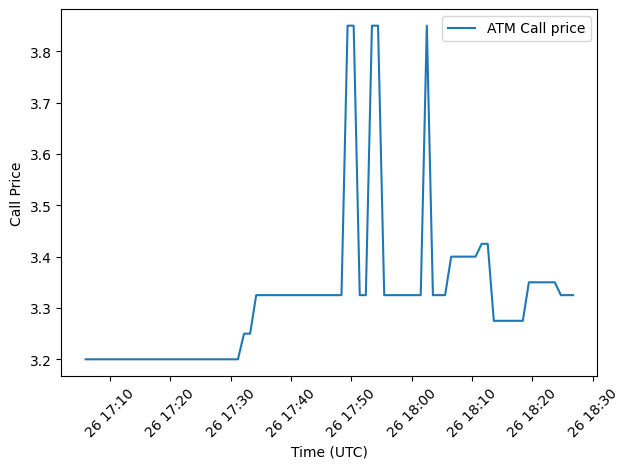

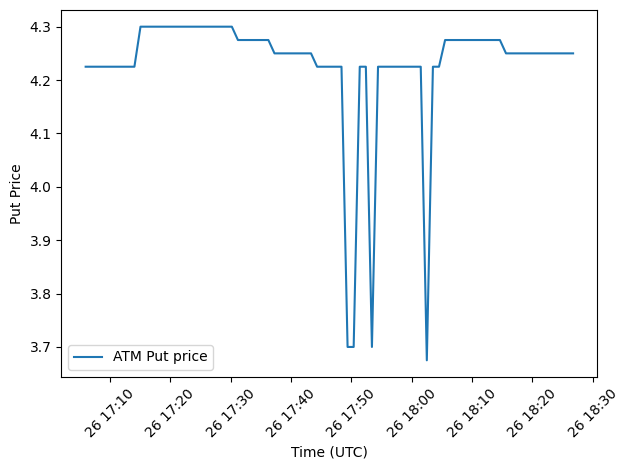

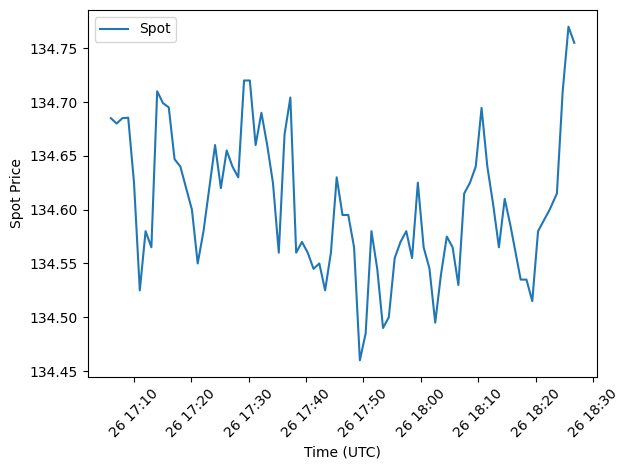

In [ ]:
ticker = "XOM"
target_days = 30
refresh_seconds = 60
max_points = 240

history = []

while True:
    clear_output(wait=True)

    now_str = datetime.now(timezone.utc).strftime("%H:%M:%S UTC")

    snap, err = snapshot_atm_prices(ticker=ticker, target_days=target_days, max_retries=3)

    if snap is None:
        print(f"Last update: {now_str} | No data yet. Reason: {err}")
        # IMPORTANT: si tu vois des erreurs 429 / cookie, augmente à 120-180
        time.sleep(refresh_seconds)
        continue

    history.append(snap)
    if len(history) > max_points:
        history = history[-max_points:]

    df = pd.DataFrame(history)
    df_plot = df.copy()
    df_plot["time"] = pd.to_datetime(df_plot["time"], utc=True).dt.tz_convert(None)

    last = df.iloc[-1]
    print(
        f"Last update: {now_str} | {ticker} spot={last['spot']:.2f} | exp={last['expiry']} | "
        f"K_call={last['K_call']:.2f} | K_put={last['K_put']:.2f} | "
        f"Call={last['call_price']:.4f} | Put={last['put_price']:.4f}"
    )

    # Call
    fig1 = plt.figure()
    plt.plot(df_plot["time"], df_plot["call_price"], label="ATM Call price")
    plt.legend(); plt.xlabel("Time (UTC)"); plt.ylabel("Call Price")
    plt.xticks(rotation=45); plt.tight_layout()
    display(fig1); plt.close(fig1)

    # Put
    fig2 = plt.figure()
    plt.plot(df_plot["time"], df_plot["put_price"], label="ATM Put price")
    plt.legend(); plt.xlabel("Time (UTC)"); plt.ylabel("Put Price")
    plt.xticks(rotation=45); plt.tight_layout()
    display(fig2); plt.close(fig2)

    # Spot
    fig3 = plt.figure()
    plt.plot(df_plot["time"], df_plot["spot"], label="Spot")
    plt.legend(); plt.xlabel("Time (UTC)"); plt.ylabel("Spot Price")
    plt.xticks(rotation=45); plt.tight_layout()
    display(fig3); plt.close(fig3)

    time.sleep(refresh_seconds)